<a href="https://colab.research.google.com/github/Kidjin04/Test-repo/blob/main/vae_%EC%88%98%EC%97%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()
#mnist읽어 들이기
print(x_train.shape, x_test.shape)  #28 x 28의 손으로 쓴 문자  이미지가 6만장

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


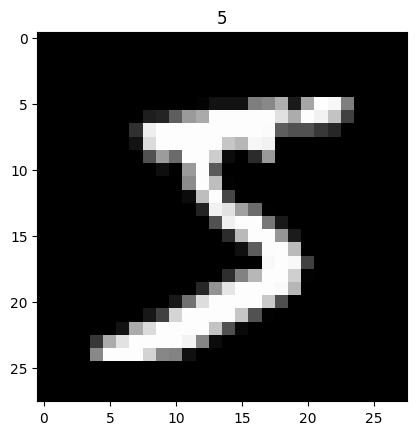

훈련용 데이터의 형태: (60000, 784) 테스트용 데이터의 형태: (10000, 784)


In [ ]:
x_train = x_train / 255
x_test = x_test / 255

#손으로 쓴 문자 이미지를 1개 표시
plt.imshow(x_train[0].reshape(28,28), cmap="gray")
plt.title(t_train[0])
plt.show()

#1차원으로 변환한다
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print("훈련용 데이터의 형태:", x_train.shape, "테스트용 데이터의 형태:", x_test.shape)

In [ ]:
epochs = 10
batch_size = 128
n_in_out = 784    #입출력층의 뉴련 수
n_z = 2     #잠재 변수의 수(차원 수)
n_mid = 256    #중간층의 뉴련수

In [ ]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import metrics         #평가 함수
from tensorflow.python.keras.layers import Input, Dense, Lambda
from tensorflow.python.keras import backend as K   #난수의 발생에 사용

In [ ]:
#잠재변수를 샘플링하기 위한 함수
def z_sample(args):
  mu, log_var = args    #잠재 변수의 평균값과 분산의 대수
  epsilon = K.random_normal(shape=K.shape(log_var), mean=0,stddev=1)
  return mu + epsilon # K.exp(log_var / 2)    #reparametrization Trick에 의해 잠재 변수를 구한다


In [ ]:
# encoder
x = Input(shape=(n_in_out,))
h_encoder = Dense(n_mid, activation="relu")(x)     
mu = Dense(n_z)(h_encoder)
log_var = Dense(n_z)(h_encoder)
z = Lambda(z_sample, output_shape=(n_z,))([mu,log_var])

In [ ]:
#Decoder

mid_decoder = Dense(n_mid, activation="relu")  #뒤에서 사용
h_decoder = mid_decoder(z)
out_decoder = Dense(n_in_out, activation="sigmoid")   #뒤에서 사용 
y = out_decoder(h_decoder)        #재구성 오차

In [ ]:
#vae 모델을 생성
model_vae = Model(x,y)

#손실함수
eps = 1e-7   #log안이 0이 되는 것을 막는다
rec_loss = K.sum(-x*K.log(y+eps) - (1-x)*K.log(1 - y+eps))/batch_size

In [ ]:
reg_loss = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var)) / batch_size
vae_loss = rec_loss + reg_loss   #정칙화 사용

model_vae.add_loss(vae_loss)
model_vae.compile(optimizer="adam")
model_vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            514         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense[0][0]                      
____________________________________________________________________________________________

In [ ]:
model_vae.fit(x_train, x_train,
              shuffle=True,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_test, None))

Epoch 1/10
469/469 [==============================] - 5s 3ms/step - loss: 210.6870 - val_loss: 181.4922
Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 181.4717 - val_loss: 177.6788
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 179.2233 - val_loss: 176.6490
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 178.1903 - val_loss: 176.0914
Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 177.4587 - val_loss: 175.5204
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 176.9842 - val_loss: 175.1853
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 176.6548 - val_loss: 174.6205
Epoch 8/10
469/469 [==============================] - 1s 3ms/step - loss: 176.3459 - val_loss: 174.1537
Epoch 9/10
469/469 [==============================] - 2s 3ms/step - loss: 176.0451 - val_loss: 174.1496
Epoch 10/10
469/469 [==============================] - 2s 3ms/st

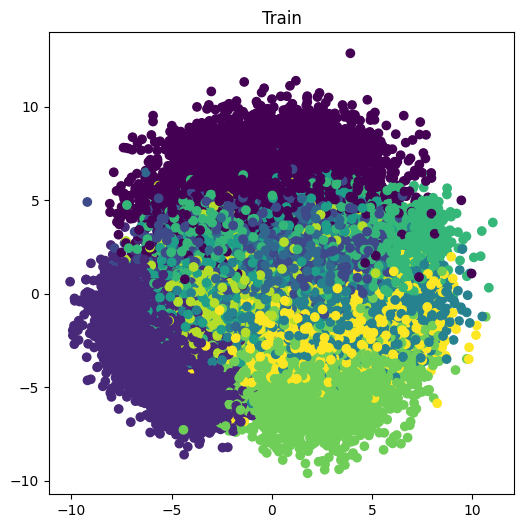

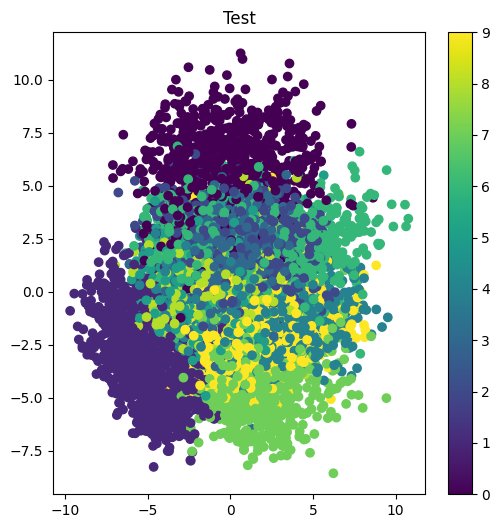

In [ ]:
#잠재 변수를 얻기 위한 모델
encoder = Model(x, z)

#훈련 데이터로부터 만든 잠재 변수를 2차원 플롯
z_train = encoder.predict(x_train, batch_size=batch_size)
plt.figure(figsize=(6,6))
plt.scatter(z_train[:, 0], z_train[:, 1], c=t_train)  #라벨을 색으로 나타낸다
plt.title("Train")
plt.colorbar
plt.show()


#테스트 데이터를 입력해서 잠재 공간에 2차원 플롯한다 정답 라벨을 색으로 표시
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6,6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=t_test)
plt.title("Test")
plt.colorbar()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

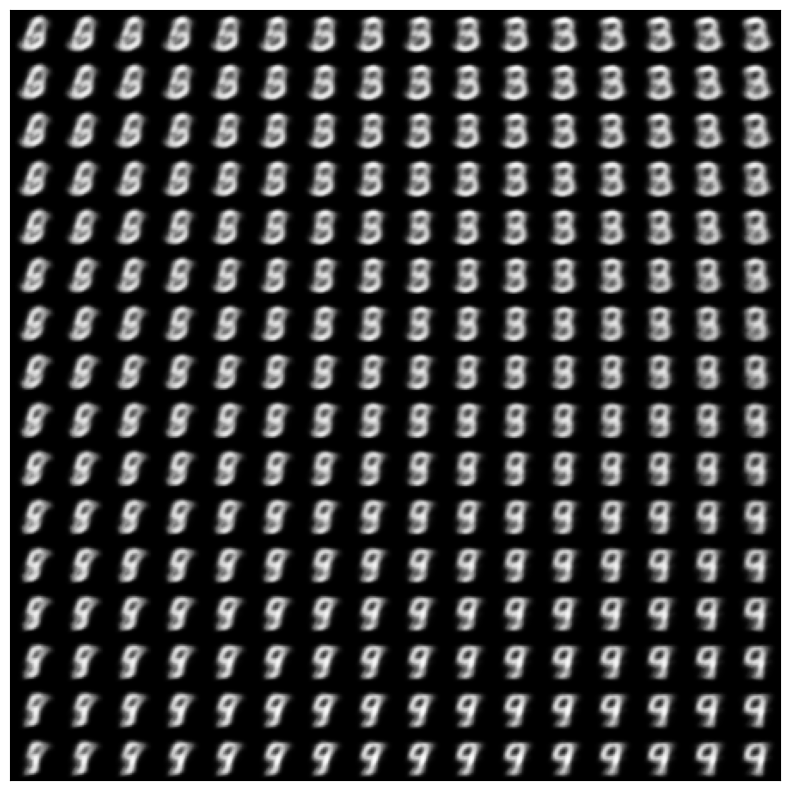

In [ ]:
#이미지 생성기
input_decoder = Input(shape=(n_z,))
h_decoder = mid_decoder(input_decoder)
y = out_decoder(h_decoder)
generator = Model(input_decoder, y)

#이미지를 나열하는 설정
n = 16  #손으로 쓴 문자 이미지를 16ㅌ16 나열한다
image_size = 28
matrix_image = np.zeros((image_size*n, image_size*n))   #전체 이미지


#잠재 변수
z_1 = np.linspace(2, -2, n)  #각 행
z_2 = np.linspace(-2, 2, n)  #각 행


#잠재 변수를 변화시켜서 이미지를 생성
for i, z1 in enumerate(z_1):
  for j, z2 in enumerate(z_2):
    decoded = generator.predict(np.array([[z2, z1]]))   # x출, y축의 순서로 넣는다
    image = decoded[0].reshape(image_size, image_size)
    matrix_image[i*image_size : (i+1)*image_size, j*image_size: (j+1)*image_size] = image

plt.figure(figsize=(10, 10))
plt.imshow(matrix_image, cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  #축 눈금의 라벨과 선을 지운다
plt.show

In [ ]:
from tensorflow.keras.datasets import fashion_mnist